In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

#  Neoclassical Growth model with a Forward Shoot Algorithm

## 1. The Problem

There is a mass of identical households that consume and save their assets from last period. They save by purchasing capital and renting it to firms - and in return they recevie the marginal return of capital. Firms produce output according to Cobb-Douglas technology ($Y_t = K_t^\alpha (A_t L_t)^{1-\alpha}$). There is a No-Ponzi condition that forbids consumers to accumulate infinite debt.

Our problem is to find a solution to two differential equations:

$$ \dot{k_t} = k_t^\alpha - (\delta + n + g)k_t - c_t$$

$$ \frac{\dot{c_t}}{c_t} = \frac{\alpha k_{t+1}^{(\alpha-1)} - (\delta + \rho + g\epsilon)}{\epsilon}$$

Which are the law of motion of capital and the Euler equation.

To simplify things, we'll work with a discrete version of the two differencial equations:

$$ k_{t+1} = k_t^\alpha - (\delta + n + g)k_t - c_t + k_t$$

$$ c_{t+1} = \frac{\alpha k_{t+1}^{(\alpha-1)} - (\delta + \rho + g\epsilon)}{\epsilon}c_t + c_t$$


## 2.The Solution (outline)

The first thing we do when facing a econ computational problem is to make an outline of how are we going to approach this problem.

As it reads in the title of the notebook, our strategy is to set a forward-shooting algorithm:

- We start in a given point, say ($k_0,c_0$) below/above the steady-state ($k^*,c^*$).
- We use the laws of motion above to advance the system forward - see were the capital-consumption path takes us.
- If we hit the steady-state, then we are done. If not, we give another guess ($k_1,c_1$) and we start again.

You can probably guess that we need to have a good strategy for updating our guess of initial point, and we go to that in a minute.

For now, we need:

- The steady-state points $k^*,c^*$
- The law of motion functions for $k_{t+1}, c_{t+1}$

And finally, we need to define some parameter values.

### 2.1 Laws of motion and steady-states

In previous notebooks, we declared the parameters inside a *dictionary*, but today I'll make an exception and we will declered them as global variables - (global means that after executing the next cell, epsilon will always be 1.0 unless you change it)

In [2]:
# Parameters
epsilon = 1.0
rho = 0.03
delta = 0.06
n = 0.01
g = 0.02
alpha = 1.0/3.0

Now that we have the parameters, it's time to code the steady-state values. 

We'll code them as functions and then store their values in the variables `kss` and `css`.

> **Exercise 1:** Type up the steady-state values of capital and consumption per effective worker (so $x_t=x_{t+1}$)

In [3]:
def kstar():
    return (alpha/(delta+rho+epsilon*g))**(1.0/(1.0-alpha))

def cstar(kss):
    return kss**alpha - (delta + n + g)*kss

kss = kstar()
css = cstar(kss)

Next we need to define functions for the law of motion. We don't need the steady-state values here, just the two equations we defined above.

These functions should take as inputs the current value of $k_t$ ($k_{t+1}$ for the Euler) and $c_t$  and return their value next period.

> **Exercise 2:** Code the (discrete) law of motion of capital and consumption

In [4]:
def capital_accumulation_eqn(kt,ct):
    ktplus1 = kt**(alpha) - (delta + n + g)*kt - ct + kt
    return ktplus1

In [5]:
def discrete_euler(ktplus1,ct):
    ctplus1 = (1.0/epsilon)*(alpha*ktplus1**(alpha-1.0) - (delta + rho + g*epsilon))*ct + ct
    return ctplus1

### 2.2 Sample path

Once the law of motions have been defined, we need to create a function that will give us the path of capital and consumption starting from any point in time.

This function will take as inputs initial points for $k$ and $c$ and a number of periods ($T$), then return a vector with the sample path for both.

> **Exercise 3:** Complete the code for `compte_sample_path`

In [6]:
def compute_sample_path(k0,c0, T):
    
    # Make room by creating two vertical vectors of lenght T+1
    k = np.empty((T+1,1))
    c = np.empty((T+1,1))
    
    # Set the first value of the vectors to be k0 and c0
    k[0] = k0
    c[0] = c0
    
    # For each time period t until T:
    for t in range(0,T):
        # Fill in k_t+1 and c_t+1 using the laws of motion
        k[t+1] = capital_accumulation_eqn(k[t],c[t])
        c[t+1] = discrete_euler(k[t+1],c[t])
    
    # When done, sew both vectors together - first k, then c
    sample_path = np.hstack([k,c])
    return sample_path

Let's call our function and see if it works

In [7]:
compute_sample_path(kss*0.5,css*0.5, 20)

array([[  2.63754024,   0.63300966],
       [  3.14880723,   0.66159673],
       [  3.66953001,   0.68151798],
       [  4.20017729,   0.69381685],
       [  4.74179583,   0.69943682],
       [  5.29561674,   0.69923778],
       [  5.86280608,   0.69400745],
       [  6.44430987,   0.68446901],
       [  7.04076341,   0.67128615],
       [  7.65244577,   0.6550664 ],
       [  8.27926654,   0.63636341],
       [  8.9207757 ,   0.61567879],
       [  9.57618947,   0.59346387],
       [ 10.24442711,   0.57012151],
       [ 10.92415415,   0.54600817],
       [ 11.6138289 ,   0.52143632],
       [ 12.31174957,   0.49667701],
       [ 13.01610012,   0.47196281],
       [ 13.72499327,   0.44749076],
       [ 14.43650982,   0.42342546],
       [ 15.14873365,   0.39990223]])

Although it is alwayws better to plot it. Remember how to do that?

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


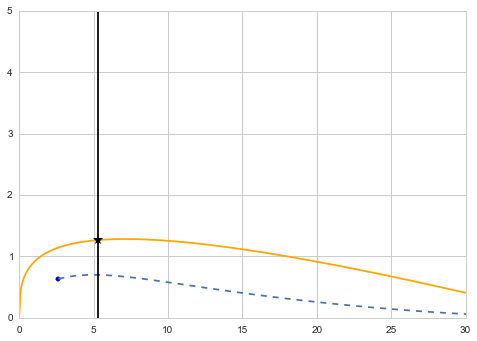

In [8]:
# Initial guesses
kguess = kss*0.5
cguess = css*0.5

# Computing smaple path
path = compute_sample_path(kguess,cguess, 100)

# Making a grid for k
kgrid = np.linspace(0, 50, 500)

# Marking the initial point using scatter
plt.scatter(kguess,cguess)

# Plotting the path using plot
plt.plot(path[:, 0],path[:,1], ls='--')

# Adding the c and k locii
plt.plot(kgrid, cstar(kgrid), color='orange', label=r'$\Delta k=0$') # Plots the K locus
plt.axvline(kss, color='black', label=r'$\Delta c=0$')               # Plots the C locus
plt.plot(kss, css, marker='*', markersize=10, color='k')             # Marks the steady state

# Setting limits of the plot so it looks nice
plt.ylim(0, 5)
plt.xlim(0,30)

# Show the plot!
plt.show()

We clearly didn't get the path right. Try with a lower value for `cguess`. What happens?

## 3. The Shooting algorithm

The previous plot should have given you an idea of how to give better guesses each time.

The shooting algorithm does precisely that: keeps trying better and better guesses until it hits the steady-state (within reason).

To get better guesses, we will use a method called [bi-section search](https://en.wikipedia.org/wiki/Bisection_method): give it a high and low intervale, and guess the middle. 

Imagine I ask you to guess a number between 0 and 100. Ypu tell em your guess and I tell you too high or too low. 

How you do it? 

- You say 50, I say *too high*
- You say 25, I say *too low*
- You say 28, I say *too high*
- You say 26, I say *too low*
- You say 27, and you got it!

That's bisection search: you know an interval and guess the middle of the interval.

### 3.1 Algorithm outline

The algorithm looks like this:
```
Given a starting point for capital, give a guess for comsuption.

Loop starts here: while distance > tolerance:

1. Calculate the distance of c and k from their statedy-state.

2. Use the law of motion of capital and the Euler for consumption to update k and c

3. Check if we are below or above the stateady state

4. Check if the distance is below tolence. If so we are done. Break the loop.

5. If it is above tolerance:
    
    5.1 If we started from below $k^*$:
        
     - Is $c>c^*$? then our initial guess for c was too...    
     - Is $k>k^*$? then our initial guess for c was too...
     
    5.2 If we started from below $k^*$:
        
     - Is $c<c^*$? then our initial guess for c was too...
     - Is $k<k^*$? then our initial guess for c was too...
     
If we have broken (exit) the previous loop, then calculate the sample path and return it.
```


We are ready to code now.

> **Exercise 4:** After compelting the pseudo code above, finish the code below for `forward_shoot`

In [9]:
def forward_shoot(k0, tol=1e-07, verbose=False):
    # compute steady state values
    k_star = kstar()
    c_star = cstar(kss)
    
    # Update the guesses
    if k0 <= k_star:
        c_l = 0
        c_h = c_star
    else:
        c_l = c_star
        c_h = k0**alpha

    c0 = (c_h + c_l) / 2
    k, c = k0, c0
    
    # Initialize a counter (to be used later)
    count  = 0
    n_iter = 0
        
    # # # # # # Forward Shooting Algorithm # # # # # # 
    # Keep doing this until we say stop ("break the loop"):
    while True:
        
        # advance the system using laws of motion
        n_iter +=1
        k = capital_accumulation_eqn(k,c)
        c = discrete_euler(k,c)
        
        # Check the distance
        dist = np.abs(((k - k_star)**2 + (c - c_star)**2)**0.5)
        # If the distance is smaller than our tolerance paramter
        if dist < tol:
            # Stop!
            break
        
        # If we want to see the progress, print it every 100 iterations
        if verbose and n_iter%100==0:
            print dist
        
        # Count how many steps we take
        count = count + 1
        
        # If we started form the left (below k*)
        if k0 <= k_star:
            
            # If k is bigger than k* (we over-did it)
            if k > k_star:
                # Update out guess
                c_l = c0
                c0 = (c_h + c_l) / 2
                # Reset the counter and the guess
                k, c = k0, c0
                count = 0
                
            # If c is bigger than c* (we over-did it)
            if c > c_star:
                # Update out guess
                c_h = c0 
                c0 = (c_h + c_l) / 2
                # Reset the counter and the guess
                k, c = k0, c0
                count = 0
                
        # If we started form the right (above k*)
        else:
            
            # If k is smaller than k* (we over-did it)
            if k < k_star:
                # Update out guess
                c_h = c0 
                c0 = (c_h + c_l) / 2
                # Reset the counter and the guess
                k, c = k0, c0
                count = 0
                
            # If c is smaller than k* (we over-did it)    
            if c < c_star:
                # Update out guess
                c_l = c0
                c0 = (c_h + c_l) / 2
                # Reset the counter and the guess
                k, c = k0, c0
                count = 0
    
    # If we got to here means that we found it! Print a Done! to let us know
    print "Done!"
    
    # Calculat the path using count as the number of steps T
    sample_path = compute_sample_path(k0,c0,count)
    
    # Return the sample path
    return sample_path

Let's try our function! Give a guess for k0 and call `forward_shoot`. 

**Tips:**

- Use the option `verbose=True` when calling the function so you see the progress.
- If your code doesn't seem to end, press the stop button above.
- If that doesn't stop it after a few seconds, "kill the kernel": > Kernel > Restart

In [10]:
c0 = 0.15*css # Not needed. Can you guess why?
k0 = kss*0.15
sample_path = forward_shoot(k0, tol=1e-07, verbose= False)

Done!


Let's plot the path!

> **Exercise 6:** Fill the gaps to plot the sample path obtained above

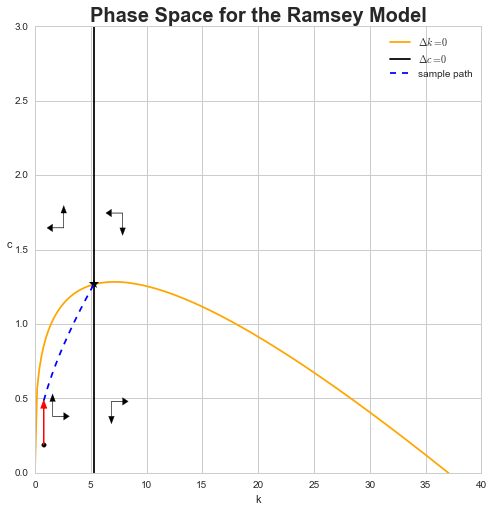

In [11]:
# Create a grid of points for plotting
gridmax, gridsize = 200, 1000
grid = np.linspace(0, gridmax, gridsize)

# Create a new figure
plt.figure(figsize=(8,8))

# Add the c and k locii
plt.plot(grid, cstar(grid), '-', color='orange', label=r'$\Delta k=0$') # Plot the K locus
plt.axvline(kss, color='black', label=r'$\Delta c=0$')  # Plot the C locus
plt.plot(kss, css, marker='*', markersize=10, color='k')

# Add the sample path
plt.plot(sample_path[:,0],sample_path[:,1], 'b--', label='sample path')

# Add the initial level of capital per worker
plt.scatter(k0,c0, color='k')

# Add the initial jump
plt.arrow(k0,c0,0,sample_path[0][1]-c0, lw=1,color='r',
          head_length=0.05,head_width=0.5,length_includes_head=True,
          label = "initial jump")

# Add arrows to indicate out of steady-state dynamics
x_len = 1 
y_len = 0.1   

plt.arrow(x=0.3 * kss, y=0.3 * css, dx=0, dy=y_len,head_length=0.05,head_width=0.5,color='black')
plt.arrow(x=0.3 * kss, y=0.3 * css, dx=x_len, dy=0,head_length=0.5,head_width=0.05,color='black')

plt.arrow(x=0.3 * kss + x_len, y=1.3 * css, dx=0, dy=y_len,head_length=0.05,head_width=0.5,color='black')
plt.arrow(x=0.3 * kss + x_len, y=1.3 * css, dx=-x_len, dy=0,head_length=0.5,head_width=0.05,color='black')

plt.arrow(x=1.3 * kss, y=0.3 * css + y_len, dx=0, dy=-y_len,head_length=0.05,head_width=0.5,color='black')
plt.arrow(x=1.3 * kss, y=0.3 * css + y_len, dx=x_len, dy=0,head_length=0.5,head_width=0.05,color='black')

plt.arrow(x=1.3 * kss + x_len, y=1.3 * css + y_len, dx=0, dy=-y_len,head_length=0.05,head_width=0.5,color='black')
plt.arrow(x=1.3 * kss + x_len, y=1.3 * css + y_len, dx=-x_len, dy=0,head_length=0.5,head_width=0.05,color='black')

# Don't forget to label your axes!
plt.xlabel('k')
plt.ylim(0, 3)
plt.xlim(0,40)
plt.ylabel('c', rotation='horizontal')

# Add a title to the plot
plt.title('Phase Space for the Ramsey Model', fontsize=20, weight='bold')

# Add the legend
plt.legend(frameon=False)

plt.show()

# That's it!

We have coded a forward shooting algorithm that solves for the saddle plath of a Neo Classical Growth Model.

This simple exercise can gives us a much more accurate solution than linearization or other techniques.

For more info on linearization and how to solve continouos case, you can check again the "Neo Classical Model - Continous version" notebook that is also in this folder.

In the next few days I will upload another notebook that introduces classes and objects, two important structures we haven't seen so far. I'll let you know when it's up.

Next stop: Solving consumption problems via Value Function Iteration!